<a href="https://colab.research.google.com/github/jerryk42/My-Colab/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning into 'My-Colab'...


sdfasfkjbddfkj

In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm  # Import tqdm for progress bars
import matplotlib.pyplot as plt  # Import matplotlib for plotting


In [ ]:
config = {
    'max_len': 256,
    'batch_size': 16,
    'learning_rate': 0.00005,
    'epochs': 50,
    'model_name': "dmis-lab/biobert-base-cased-v1.1"  # BioBERT model name
}


In [ ]:
# Set device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [ ]:
import pandas as pd

# URL of the raw file
url = "https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/refs/heads/main/data/incidents_train.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(url)

# Display the first few rows of the DataFrame
print(df.head())


   Unnamed: 0  year  month  day country                             title  \
0           0  1994      1    7      us  Recall Notification: FSIS-024-94   
1           1  1994      3   10      us  Recall Notification: FSIS-033-94   
2           2  1994      3   28      us  Recall Notification: FSIS-014-94   
3           3  1994      4    3      us  Recall Notification: FSIS-009-94   
4           4  1994      7    1      us  Recall Notification: FSIS-001-94   

                                                text hazard-category  \
0  Case Number: 024-94   \n            Date Opene...      biological   
1  Case Number: 033-94   \n            Date Opene...      biological   
2  Case Number: 014-94   \n            Date Opene...      biological   
3  Case Number: 009-94   \n            Date Opene...  foreign bodies   
4  Case Number: 001-94   \n            Date Opene...  foreign bodies   

               product-category                  hazard  \
0  meat, egg and dairy products  listeria mon

In [ ]:
# Drop the first column
df = df.drop(df.columns[0], axis=1)

In [ ]:
# Check the structure of the DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   year              5082 non-null   int64 
 1   month             5082 non-null   int64 
 2   day               5082 non-null   int64 
 3   country           5082 non-null   object
 4   title             5082 non-null   object
 5   text              5082 non-null   object
 6   hazard-category   5082 non-null   object
 7   product-category  5082 non-null   object
 8   hazard            5082 non-null   object
 9   product           5082 non-null   object
dtypes: int64(3), object(7)
memory usage: 397.2+ KB
None


In [ ]:
# Custom Dataset for Text Data
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
# Function to clean text (title or text) and remove stopwords
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()
    text = ' '.join(text.split())
    return text


In [ ]:
# Load tokenizer for Microsoft PubMedBERT model
tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

# Assuming df is your DataFrame
df['title'] = df['title'].apply(clean_text)
df['text'] = df['text'].apply(clean_text)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [ ]:
# Define relevant features and targets
features = ['year', 'month', 'day', 'country']
targets_subtask1 = ['hazard-category','product-category']
targets_subtask2 = ['hazard','product']


In [ ]:
# Encode target labels to numeric values
label_encoders = {}
for target in targets_subtask1 + targets_subtask2:
    le = LabelEncoder()
    df[target] = le.fit_transform(df[target])
    label_encoders[target] = le


In [ ]:
# Prepare data for both title and text
def prepare_data(text_column):
    X = df[features + [text_column]]
    y_subtask1 = df[targets_subtask1]
    y_subtask2 = df[targets_subtask2]

    data_splits = {}
    for target in targets_subtask1 + targets_subtask2:
        X_train, X_test, y_train, y_test = train_test_split(
            X, df[target], test_size=0.2, random_state=42
        )

        # Reset indices to ensure matching
        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
        X_test = X_test.reset_index(drop=True)
        y_test = y_test.reset_index(drop=True)

        data_splits[target] = (X_train, X_test, y_train, y_test)

    return data_splits


In [ ]:
# Prepare data for title and text
title_splits = prepare_data('title')
text_splits = prepare_data('text')


In [ ]:
def train_and_evaluate_nn(data_splits, targets, model_type='title', early_stopping_patience=6, lr_reduce_factor=0.1):
    f1_scores = []  # List to store F1 scores for each task

    for target in targets:
        print(f"\nStarting training for task: {target}")  # Print task message

        X_train, X_test, y_train, y_test = data_splits[target]

        # Prepare text data using the tokenizer
        if model_type == 'title':
            texts_train = X_train['title'].values
            texts_test = X_test['title'].values
        else:
            texts_train = X_train['text'].values
            texts_test = X_test['text'].values

        # Create DataLoader for training and testing
        train_dataset = TextDataset(texts_train, y_train, tokenizer, config['max_len'])
        test_dataset = TextDataset(texts_test, y_test, tokenizer, config['max_len'])

        train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

        # Model setup
        num_labels = len(label_encoders[target].classes_)
        model = AutoModelForSequenceClassification.from_pretrained(config['model_name'], num_labels=num_labels).to(device)

        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_reduce_factor, patience=3, verbose=True)
        criterion = nn.CrossEntropyLoss()

        # Training process
        model.train()
        best_loss = float('inf')
        early_stop_counter = 0

        for epoch in range(config['epochs']):
            print(f"Epoch {epoch+1}/{config['epochs']} - Training: {target}")
            progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}", total=len(train_loader), leave=True)
            epoch_loss = 0.0

            for batch in progress_bar:
                optimizer.zero_grad()
                input_ids = batch['input_ids'].squeeze(1).to(device)
                attention_mask = batch['attention_mask'].squeeze(1).to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                progress_bar.set_postfix(loss=loss.item())

            # Average loss for the epoch
            avg_epoch_loss = epoch_loss / len(train_loader)
            print(f"Average Training Loss for Epoch {epoch+1}: {avg_epoch_loss}")

            # Evaluate on the test set to compute validation loss
            val_loss = 0.0
            model.eval()
            with torch.no_grad():
                for batch in test_loader:
                    input_ids = batch['input_ids'].squeeze(1).to(device)
                    attention_mask = batch['attention_mask'].squeeze(1).to(device)
                    labels = batch['label'].to(device)

                    outputs = model(input_ids, attention_mask=attention_mask)
                    loss = criterion(outputs.logits, labels)
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(test_loader)
            print(f"Validation Loss after Epoch {epoch+1}: {avg_val_loss}")

            # Step the scheduler with the validation loss
            scheduler.step(avg_val_loss)

            # Early stopping check
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                early_stop_counter = 0
                torch.save(model.state_dict(), f"best_model_{target}.pt")  # Save the best model
            else:
                early_stop_counter += 1
                print(f"Early stopping counter: {early_stop_counter}/{early_stopping_patience}")

            if early_stop_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break

        # Load the best model for evaluation
        model.load_state_dict(torch.load(f"best_model_{target}.pt"))

        # Evaluation process
        print(f"Evaluating model for task: {target}")
        model.eval()
        y_preds = []
        y_true = []
        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Evaluating", total=len(test_loader), leave=True):
                input_ids = batch['input_ids'].squeeze(1).to(device)
                attention_mask = batch['attention_mask'].squeeze(1).to(device)
                labels = batch['label'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask)
                _, preds = torch.max(outputs.logits, dim=1)
                y_preds.extend(preds.cpu().numpy())
                y_true.extend(labels.cpu().numpy())

        # Decode labels back to original categories using the label encoder
        decoded_preds = label_encoders[target].inverse_transform(y_preds)
        decoded_true = label_encoders[target].inverse_transform(y_true)

        # Calculate F1 score for the task
        f1 = f1_score(decoded_true, decoded_preds, average='weighted')
        f1_scores.append(f1)
        print(f"F1-Score for {target}: {f1}")

        # Print classification report
        print(f"Classification Report for {target}:\n")
        print(classification_report(decoded_true, decoded_preds, zero_division=0))

    return f1_scores  # Return the list of F1 scores for plotting


In [ ]:
# Train and evaluate for both title and text
print("\nTraining and Evaluating for Title Tasks:")
title_f1_scores = train_and_evaluate_nn(title_splits, targets_subtask1 + targets_subtask2, model_type='title')

print("\nTraining and Evaluating for Text Tasks:")
text_f1_scores = train_and_evaluate_nn(text_splits, targets_subtask1 + targets_subtask2, model_type='text')



Training and Evaluating for Title Tasks:

Starting training for task: hazard-category


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/25 - Training: hazard-category


Training Epoch 1: 100%|██████████| 255/255 [01:12<00:00,  3.49it/s, loss=0.272]


Average Training Loss for Epoch 1: 0.855338263277914
Validation Loss after Epoch 1: 0.6472745211794972
Epoch 2/25 - Training: hazard-category


Training Epoch 2: 100%|██████████| 255/255 [01:13<00:00,  3.48it/s, loss=0.00513]


Average Training Loss for Epoch 2: 0.4958556231111288
Validation Loss after Epoch 2: 0.6145218464080244
Epoch 3/25 - Training: hazard-category


Training Epoch 3: 100%|██████████| 255/255 [01:12<00:00,  3.49it/s, loss=2.44]


Average Training Loss for Epoch 3: 0.33928195284862145
Validation Loss after Epoch 3: 0.6001030334737152
Epoch 4/25 - Training: hazard-category


Training Epoch 4: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=0.0486]


Average Training Loss for Epoch 4: 0.2190404400631201
Validation Loss after Epoch 4: 0.683858520234935
Early stopping counter: 1/5
Epoch 5/25 - Training: hazard-category


Training Epoch 5: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=0.00739]


Average Training Loss for Epoch 5: 0.13618044207310853
Validation Loss after Epoch 5: 0.6799268068280071
Early stopping counter: 2/5
Epoch 6/25 - Training: hazard-category


Training Epoch 6: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=0.0203]


Average Training Loss for Epoch 6: 0.08468361487429515
Validation Loss after Epoch 6: 0.7713596922694705
Early stopping counter: 3/5
Epoch 7/25 - Training: hazard-category


Training Epoch 7: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=0.000711]


Average Training Loss for Epoch 7: 0.04122199397671091
Validation Loss after Epoch 7: 0.7426563010085374
Early stopping counter: 4/5
Epoch 8/25 - Training: hazard-category


Training Epoch 8: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=0.000636]


Average Training Loss for Epoch 8: 0.025054675095038965
Validation Loss after Epoch 8: 0.7556469244591426
Early stopping counter: 5/5
Early stopping triggered.


<ipython-input-19-54c1aaee6c7a>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: hazard-category


Evaluating: 100%|██████████| 64/64 [00:05<00:00, 11.14it/s]


F1-Score for hazard-category: 0.8173977417121364
Classification Report for hazard-category:

                                precision    recall  f1-score   support

                     allergens       0.90      0.89      0.89       377
                    biological       0.81      0.94      0.87       339
                      chemical       0.69      0.74      0.71        68
food additives and flavourings       0.00      0.00      0.00         5
                foreign bodies       0.82      0.72      0.77       111
                         fraud       0.73      0.56      0.63        68
                     migration       0.00      0.00      0.00         1
          organoleptic aspects       0.38      0.30      0.33        10
                  other hazard       0.71      0.44      0.55        27
              packaging defect       0.75      0.27      0.40        11

                      accuracy                           0.83      1017
                     macro avg       0.58

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/25 - Training: product-category


Training Epoch 1: 100%|██████████| 255/255 [01:14<00:00,  3.44it/s, loss=1.06]


Average Training Loss for Epoch 1: 1.945509958267212
Validation Loss after Epoch 1: 1.330814472399652
Epoch 2/25 - Training: product-category


Training Epoch 2: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=0.0521]


Average Training Loss for Epoch 2: 1.0262521598268957
Validation Loss after Epoch 2: 1.0367943863384426
Epoch 3/25 - Training: product-category


Training Epoch 3: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=0.307]


Average Training Loss for Epoch 3: 0.6208991337640613
Validation Loss after Epoch 3: 0.9705143482424319
Epoch 4/25 - Training: product-category


Training Epoch 4: 100%|██████████| 255/255 [01:13<00:00,  3.48it/s, loss=4.71]


Average Training Loss for Epoch 4: 0.35893641830805467
Validation Loss after Epoch 4: 0.9697813126258552
Epoch 5/25 - Training: product-category


Training Epoch 5: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=0.0207]


Average Training Loss for Epoch 5: 0.19147846112940825
Validation Loss after Epoch 5: 1.019515844527632
Early stopping counter: 1/5
Epoch 6/25 - Training: product-category


Training Epoch 6: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=0.0137]


Average Training Loss for Epoch 6: 0.10976380524682064
Validation Loss after Epoch 6: 1.0313474864233285
Early stopping counter: 2/5
Epoch 7/25 - Training: product-category


Training Epoch 7: 100%|██████████| 255/255 [01:13<00:00,  3.48it/s, loss=0.00433]


Average Training Loss for Epoch 7: 0.07095211905372494
Validation Loss after Epoch 7: 1.0989235881716013
Early stopping counter: 3/5
Epoch 8/25 - Training: product-category


Training Epoch 8: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=0.0021]


Average Training Loss for Epoch 8: 0.03910395023504309
Validation Loss after Epoch 8: 1.0847301576286554
Early stopping counter: 4/5
Epoch 9/25 - Training: product-category


Training Epoch 9: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=0.00142]


Average Training Loss for Epoch 9: 0.024250741998719818
Validation Loss after Epoch 9: 1.097368695307523
Early stopping counter: 5/5
Early stopping triggered.


<ipython-input-19-54c1aaee6c7a>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: product-category


Evaluating: 100%|██████████| 64/64 [00:05<00:00, 11.13it/s]


F1-Score for product-category: 0.7540731385760469
Classification Report for product-category:

                                                   precision    recall  f1-score   support

                              alcoholic beverages       0.71      0.71      0.71         7
                      cereals and bakery products       0.75      0.72      0.74       123
     cocoa and cocoa preparations, coffee and tea       0.81      0.69      0.75        49
                                    confectionery       0.68      0.42      0.52        40
dietetic foods, food supplements, fortified foods       0.61      0.71      0.65        24
                                    fats and oils       1.00      0.50      0.67         4
                                   feed materials       0.00      0.00      0.00         3
                           food contact materials       0.00      0.00      0.00         1
                            fruits and vegetables       0.74      0.82      0.78     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/25 - Training: hazard


Training Epoch 1: 100%|██████████| 255/255 [01:14<00:00,  3.43it/s, loss=3.54]


Average Training Loss for Epoch 1: 3.1356256251241645
Validation Loss after Epoch 1: 2.3881458435207605
Epoch 2/25 - Training: hazard


Training Epoch 2: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=0.0443]


Average Training Loss for Epoch 2: 2.00813330053991
Validation Loss after Epoch 2: 2.039768203161657
Epoch 3/25 - Training: hazard


Training Epoch 3: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=0.0183]


Average Training Loss for Epoch 3: 1.4919777257258402
Validation Loss after Epoch 3: 1.8825689563527703
Epoch 4/25 - Training: hazard


Training Epoch 4: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=0.28]


Average Training Loss for Epoch 4: 1.0792154898830488
Validation Loss after Epoch 4: 1.8002545144408941
Epoch 5/25 - Training: hazard


Training Epoch 5: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=2.16]


Average Training Loss for Epoch 5: 0.7660953540135832
Validation Loss after Epoch 5: 1.8195726815611124
Early stopping counter: 1/5
Epoch 6/25 - Training: hazard


Training Epoch 6: 100%|██████████| 255/255 [01:13<00:00,  3.48it/s, loss=0.12]


Average Training Loss for Epoch 6: 0.5457772553551431
Validation Loss after Epoch 6: 1.8287476524710655
Early stopping counter: 2/5
Epoch 7/25 - Training: hazard


Training Epoch 7: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=0.00436]


Average Training Loss for Epoch 7: 0.38325727102255414
Validation Loss after Epoch 7: 1.8729222137480974
Early stopping counter: 3/5
Epoch 8/25 - Training: hazard


Training Epoch 8: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=2.2]


Average Training Loss for Epoch 8: 0.26847992187329367
Validation Loss after Epoch 8: 1.8436499992385507
Early stopping counter: 4/5
Epoch 9/25 - Training: hazard


Training Epoch 9: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=0.00974]


Average Training Loss for Epoch 9: 0.21193741735290078
Validation Loss after Epoch 9: 1.8296370189636946
Early stopping counter: 5/5
Early stopping triggered.


<ipython-input-19-54c1aaee6c7a>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: hazard


Evaluating: 100%|██████████| 64/64 [00:05<00:00, 11.12it/s]


F1-Score for hazard: 0.595420976617329
Classification Report for hazard:

                                                   precision    recall  f1-score   support

                                        Aflatoxin       1.00      0.50      0.67         4
                                  alcohol content       0.00      0.00      0.00         1
                                        alkaloids       0.00      0.00      0.00         2
                                        allergens       0.00      0.00      0.00         4
                                           almond       0.64      0.64      0.64        14
             altered organoleptic characteristics       0.00      0.00      0.00         2
                                        amygdalin       0.00      0.00      0.00         2
                           antibiotics, vet drugs       0.00      0.00      0.00         1
                                    bacillus spp.       0.00      0.00      0.00         1
               

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/25 - Training: product


Training Epoch 1: 100%|██████████| 255/255 [01:14<00:00,  3.43it/s, loss=6.77]


Average Training Loss for Epoch 1: 6.287185010723039
Validation Loss after Epoch 1: 5.835066668689251
Epoch 2/25 - Training: product


Training Epoch 2: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=0.849]


Average Training Loss for Epoch 2: 5.197389466154809
Validation Loss after Epoch 2: 5.192511681467295
Epoch 3/25 - Training: product


Training Epoch 3: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=2.62]


Average Training Loss for Epoch 3: 4.34722642992057
Validation Loss after Epoch 3: 4.6527847945690155
Epoch 4/25 - Training: product


Training Epoch 4: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=5.93]


Average Training Loss for Epoch 4: 3.6290772311827717
Validation Loss after Epoch 4: 4.37174092233181
Epoch 5/25 - Training: product


Training Epoch 5: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=5.26]


Average Training Loss for Epoch 5: 2.98111146291097
Validation Loss after Epoch 5: 4.131615586578846
Epoch 6/25 - Training: product


Training Epoch 6: 100%|██████████| 255/255 [01:13<00:00,  3.48it/s, loss=0.0443]


Average Training Loss for Epoch 6: 2.402602133987581
Validation Loss after Epoch 6: 3.8971640150994062
Epoch 7/25 - Training: product


Training Epoch 7: 100%|██████████| 255/255 [01:13<00:00,  3.48it/s, loss=1.59]


Average Training Loss for Epoch 7: 1.9303643911492592
Validation Loss after Epoch 7: 3.787639956921339
Epoch 8/25 - Training: product


Training Epoch 8: 100%|██████████| 255/255 [01:13<00:00,  3.48it/s, loss=0.132]


Average Training Loss for Epoch 8: 1.5477656432810951
Validation Loss after Epoch 8: 3.7061036936938763
Epoch 9/25 - Training: product


Training Epoch 9: 100%|██████████| 255/255 [01:13<00:00,  3.48it/s, loss=0.0347]


Average Training Loss for Epoch 9: 1.236795020468679
Validation Loss after Epoch 9: 3.6597837414592505
Epoch 10/25 - Training: product


Training Epoch 10: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=0.131]


Average Training Loss for Epoch 10: 0.9827708984706917
Validation Loss after Epoch 10: 3.582615030929446
Epoch 11/25 - Training: product


Training Epoch 11: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=1.42]


Average Training Loss for Epoch 11: 0.7916653808425455
Validation Loss after Epoch 11: 3.567703701555729
Epoch 12/25 - Training: product


Training Epoch 12: 100%|██████████| 255/255 [01:13<00:00,  3.48it/s, loss=0.1]


Average Training Loss for Epoch 12: 0.6468898795691191
Validation Loss after Epoch 12: 3.5530740804970264
Epoch 13/25 - Training: product


Training Epoch 13: 100%|██████████| 255/255 [01:13<00:00,  3.48it/s, loss=0.517]


Average Training Loss for Epoch 13: 0.5119451585353589
Validation Loss after Epoch 13: 3.5429931934922934
Epoch 14/25 - Training: product


Training Epoch 14: 100%|██████████| 255/255 [01:13<00:00,  3.48it/s, loss=0.0405]


Average Training Loss for Epoch 14: 0.41556841303028313
Validation Loss after Epoch 14: 3.557899381965399
Early stopping counter: 1/5
Epoch 15/25 - Training: product


Training Epoch 15: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=0.23]


Average Training Loss for Epoch 15: 0.3338605275925468
Validation Loss after Epoch 15: 3.539125105366111
Epoch 16/25 - Training: product


Training Epoch 16: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=0.0127]


Average Training Loss for Epoch 16: 0.26405981493127695
Validation Loss after Epoch 16: 3.56685746088624
Early stopping counter: 1/5
Epoch 17/25 - Training: product


Training Epoch 17: 100%|██████████| 255/255 [01:13<00:00,  3.48it/s, loss=0.0856]


Average Training Loss for Epoch 17: 0.20904818755738874
Validation Loss after Epoch 17: 3.564756779000163
Early stopping counter: 2/5
Epoch 18/25 - Training: product


Training Epoch 18: 100%|██████████| 255/255 [01:13<00:00,  3.48it/s, loss=0.346]


Average Training Loss for Epoch 18: 0.16549866906568117
Validation Loss after Epoch 18: 3.596835942938924
Early stopping counter: 3/5
Epoch 19/25 - Training: product


Training Epoch 19: 100%|██████████| 255/255 [01:13<00:00,  3.48it/s, loss=0.0362]


Average Training Loss for Epoch 19: 0.12614172584578104
Validation Loss after Epoch 19: 3.585861338302493
Early stopping counter: 4/5
Epoch 20/25 - Training: product


Training Epoch 20: 100%|██████████| 255/255 [01:13<00:00,  3.49it/s, loss=0.012]


Average Training Loss for Epoch 20: 0.11319642818587668
Validation Loss after Epoch 20: 3.5889666844159365
Early stopping counter: 5/5
Early stopping triggered.


<ipython-input-19-54c1aaee6c7a>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: product


Evaluating: 100%|██████████| 64/64 [00:05<00:00, 11.10it/s]


F1-Score for product: 0.4605558064660445
Classification Report for product:

                                                   precision    recall  f1-score   support

                           Catfishes (freshwater)       0.75      0.60      0.67         5
                            Fishes not identified       0.50      0.67      0.57         6
                         Not classified pork meat       0.17      0.33      0.22         3
                       Pangas catfishes (generic)       0.00      0.00      0.00         1
              Precooked cooked pork meat products       0.00      0.00      0.00         1
                                    Veggie Burger       1.00      0.50      0.67         2
                               after dinner mints       0.00      0.00      0.00         1
                                  alfalfa sprouts       0.00      0.00      0.00         0
                                            algae       0.75      1.00      0.86         3
            

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/25 - Training: hazard-category


Training Epoch 1: 100%|██████████| 255/255 [01:25<00:00,  2.99it/s, loss=0.0756]


Average Training Loss for Epoch 1: 0.5871426617397981
Validation Loss after Epoch 1: 0.34109166043344885
Epoch 2/25 - Training: hazard-category


Training Epoch 2: 100%|██████████| 255/255 [01:24<00:00,  3.03it/s, loss=0.0126]


Average Training Loss for Epoch 2: 0.28107682288642605
Validation Loss after Epoch 2: 0.25387111617601477
Epoch 3/25 - Training: hazard-category


Training Epoch 3: 100%|██████████| 255/255 [01:24<00:00,  3.03it/s, loss=0.0025]


Average Training Loss for Epoch 3: 0.18668679867451096
Validation Loss after Epoch 3: 0.2638106846716255
Early stopping counter: 1/5
Epoch 4/25 - Training: hazard-category


Training Epoch 4: 100%|██████████| 255/255 [01:24<00:00,  3.03it/s, loss=0.00229]


Average Training Loss for Epoch 4: 0.15125678902327577
Validation Loss after Epoch 4: 0.21985904933535494
Epoch 5/25 - Training: hazard-category


Training Epoch 5: 100%|██████████| 255/255 [01:24<00:00,  3.03it/s, loss=0.00175]


Average Training Loss for Epoch 5: 0.10898015240992548
Validation Loss after Epoch 5: 0.25588769937166944
Early stopping counter: 1/5
Epoch 6/25 - Training: hazard-category


Training Epoch 6: 100%|██████████| 255/255 [01:24<00:00,  3.03it/s, loss=0.0874]


Average Training Loss for Epoch 6: 0.08956126586588867
Validation Loss after Epoch 6: 0.22791999306355137
Early stopping counter: 2/5
Epoch 7/25 - Training: hazard-category


Training Epoch 7: 100%|██████████| 255/255 [01:24<00:00,  3.03it/s, loss=0.0046]


Average Training Loss for Epoch 7: 0.07820594150153007
Validation Loss after Epoch 7: 0.265801327634108
Early stopping counter: 3/5
Epoch 8/25 - Training: hazard-category


Training Epoch 8: 100%|██████████| 255/255 [01:24<00:00,  3.03it/s, loss=0.00276]


Average Training Loss for Epoch 8: 0.03240363457988875
Validation Loss after Epoch 8: 0.2714330933195015
Early stopping counter: 4/5
Epoch 9/25 - Training: hazard-category


Training Epoch 9: 100%|██████████| 255/255 [01:24<00:00,  3.03it/s, loss=0.0414]


Average Training Loss for Epoch 9: 0.01785263269272286
Validation Loss after Epoch 9: 0.28461519072880037
Early stopping counter: 5/5
Early stopping triggered.


<ipython-input-19-54c1aaee6c7a>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: hazard-category


Evaluating: 100%|██████████| 64/64 [00:06<00:00,  9.45it/s]


F1-Score for hazard-category: 0.9404410788193238
Classification Report for hazard-category:

                                precision    recall  f1-score   support

                     allergens       0.95      0.97      0.96       377
                    biological       0.99      0.99      0.99       339
                      chemical       0.88      0.97      0.92        68
food additives and flavourings       0.50      0.40      0.44         5
                foreign bodies       0.98      0.99      0.99       111
                         fraud       0.80      0.69      0.74        68
                     migration       0.00      0.00      0.00         1
          organoleptic aspects       0.64      0.90      0.75        10
                  other hazard       0.75      0.67      0.71        27
              packaging defect       1.00      0.45      0.62        11

                      accuracy                           0.94      1017
                     macro avg       0.75

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/25 - Training: product-category


Training Epoch 1: 100%|██████████| 255/255 [01:25<00:00,  2.99it/s, loss=2.68]


Average Training Loss for Epoch 1: 2.3007026335772345
Validation Loss after Epoch 1: 2.140275876969099
Epoch 2/25 - Training: product-category


Training Epoch 2: 100%|██████████| 255/255 [01:23<00:00,  3.05it/s, loss=1.8]


Average Training Loss for Epoch 2: 2.0568174245310766
Validation Loss after Epoch 2: 1.988776994869113
Epoch 3/25 - Training: product-category


Training Epoch 3: 100%|██████████| 255/255 [01:23<00:00,  3.04it/s, loss=0.305]


Average Training Loss for Epoch 3: 1.8152829427345127
Validation Loss after Epoch 3: 1.6987481554970145
Epoch 4/25 - Training: product-category


Training Epoch 4: 100%|██████████| 255/255 [01:24<00:00,  3.03it/s, loss=1.49]


Average Training Loss for Epoch 4: 1.3514968242131027
Validation Loss after Epoch 4: 1.3094891039654613
Epoch 5/25 - Training: product-category


Training Epoch 5: 100%|██████████| 255/255 [01:23<00:00,  3.04it/s, loss=0.0318]


Average Training Loss for Epoch 5: 1.0917525384502083
Validation Loss after Epoch 5: 1.1158345462754369
Epoch 6/25 - Training: product-category


Training Epoch 6: 100%|██████████| 255/255 [01:24<00:00,  3.04it/s, loss=0.0819]


Average Training Loss for Epoch 6: 0.7217575621078997
Validation Loss after Epoch 6: 1.1329219951294363
Early stopping counter: 1/5
Epoch 7/25 - Training: product-category


Training Epoch 7: 100%|██████████| 255/255 [01:24<00:00,  3.03it/s, loss=0.135]


Average Training Loss for Epoch 7: 0.4990827176792949
Validation Loss after Epoch 7: 1.1384462183341384
Early stopping counter: 2/5
Epoch 8/25 - Training: product-category


Training Epoch 8: 100%|██████████| 255/255 [01:24<00:00,  3.03it/s, loss=0.136]


Average Training Loss for Epoch 8: 0.35667272331375705
Validation Loss after Epoch 8: 1.1345398868434131
Early stopping counter: 3/5
Epoch 9/25 - Training: product-category


Training Epoch 9: 100%|██████████| 255/255 [01:24<00:00,  3.03it/s, loss=0.0454]


Average Training Loss for Epoch 9: 0.18477513744842772
Validation Loss after Epoch 9: 1.1006520583759993
Epoch 10/25 - Training: product-category


Training Epoch 10: 100%|██████████| 255/255 [01:24<00:00,  3.03it/s, loss=0.00421]


Average Training Loss for Epoch 10: 0.12365285598435531
Validation Loss after Epoch 10: 1.1226495334412903
Early stopping counter: 1/5
Epoch 11/25 - Training: product-category


Training Epoch 11: 100%|██████████| 255/255 [01:24<00:00,  3.03it/s, loss=0.0038]


Average Training Loss for Epoch 11: 0.09573516423777476
Validation Loss after Epoch 11: 1.1502299767453223
Early stopping counter: 2/5
Epoch 12/25 - Training: product-category


Training Epoch 12: 100%|██████████| 255/255 [01:24<00:00,  3.03it/s, loss=0.00646]


Average Training Loss for Epoch 12: 0.0744402129842224
Validation Loss after Epoch 12: 1.178855327423662
Early stopping counter: 3/5
Epoch 13/25 - Training: product-category


Training Epoch 13: 100%|██████████| 255/255 [01:24<00:00,  3.03it/s, loss=0.00604]


Average Training Loss for Epoch 13: 0.06132496409848624
Validation Loss after Epoch 13: 1.1784462700597942
Early stopping counter: 4/5
Epoch 14/25 - Training: product-category


Training Epoch 14: 100%|██████████| 255/255 [01:24<00:00,  3.03it/s, loss=0.00486]


Average Training Loss for Epoch 14: 0.05762032814616082
Validation Loss after Epoch 14: 1.1823344703298062
Early stopping counter: 5/5
Early stopping triggered.


<ipython-input-19-54c1aaee6c7a>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: product-category


Evaluating: 100%|██████████| 64/64 [00:06<00:00,  9.44it/s]


F1-Score for product-category: 0.7472008834874513
Classification Report for product-category:

                                                   precision    recall  f1-score   support

                              alcoholic beverages       0.71      0.71      0.71         7
                      cereals and bakery products       0.70      0.72      0.71       123
     cocoa and cocoa preparations, coffee and tea       0.77      0.73      0.75        49
                                    confectionery       0.46      0.45      0.46        40
dietetic foods, food supplements, fortified foods       0.73      0.79      0.76        24
                                    fats and oils       0.67      0.50      0.57         4
                                   feed materials       0.00      0.00      0.00         3
                   food additives and flavourings       0.00      0.00      0.00         0
                           food contact materials       0.00      0.00      0.00     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/25 - Training: hazard


Training Epoch 1: 100%|██████████| 255/255 [01:25<00:00,  2.99it/s, loss=4.21]


Average Training Loss for Epoch 1: 2.621822358112709
Validation Loss after Epoch 1: 1.5108891343697906
Epoch 2/25 - Training: hazard


Training Epoch 2: 100%|██████████| 255/255 [01:24<00:00,  3.02it/s, loss=4.49]


Average Training Loss for Epoch 2: 1.1984890492523417
Validation Loss after Epoch 2: 1.1247173133306205
Epoch 3/25 - Training: hazard


Training Epoch 3: 100%|██████████| 255/255 [01:24<00:00,  3.02it/s, loss=0.0211]


Average Training Loss for Epoch 3: 0.8400494390989051
Validation Loss after Epoch 3: 0.9427493214607239
Epoch 4/25 - Training: hazard


Training Epoch 4: 100%|██████████| 255/255 [01:24<00:00,  3.02it/s, loss=0.0301]


Average Training Loss for Epoch 4: 0.613024930400299
Validation Loss after Epoch 4: 0.8511855482356623
Epoch 5/25 - Training: hazard


Training Epoch 5: 100%|██████████| 255/255 [01:24<00:00,  3.02it/s, loss=0.0155]


Average Training Loss for Epoch 5: 0.45601792094462057
Validation Loss after Epoch 5: 0.8264280882431194
Epoch 6/25 - Training: hazard


Training Epoch 6: 100%|██████████| 255/255 [01:24<00:00,  3.02it/s, loss=0.0111]


Average Training Loss for Epoch 6: 0.33962089251361643
Validation Loss after Epoch 6: 0.7991745021718089
Epoch 7/25 - Training: hazard


Training Epoch 7: 100%|██████████| 255/255 [01:24<00:00,  3.01it/s, loss=0.0845]


Average Training Loss for Epoch 7: 0.24869923384166231
Validation Loss after Epoch 7: 0.8053500618552789
Early stopping counter: 1/5
Epoch 8/25 - Training: hazard


Training Epoch 8: 100%|██████████| 255/255 [01:24<00:00,  3.01it/s, loss=0.373]


Average Training Loss for Epoch 8: 0.1950328236299695
Validation Loss after Epoch 8: 0.8230063410010189
Early stopping counter: 2/5
Epoch 9/25 - Training: hazard


Training Epoch 9: 100%|██████████| 255/255 [01:24<00:00,  3.02it/s, loss=0.014]


Average Training Loss for Epoch 9: 0.15079908273821951
Validation Loss after Epoch 9: 0.8352539735496975
Early stopping counter: 3/5
Epoch 10/25 - Training: hazard


Training Epoch 10: 100%|██████████| 255/255 [01:24<00:00,  3.02it/s, loss=0.0413]


Average Training Loss for Epoch 10: 0.09245947003729788
Validation Loss after Epoch 10: 0.8122221869416535
Early stopping counter: 4/5
Epoch 11/25 - Training: hazard


Training Epoch 11: 100%|██████████| 255/255 [01:24<00:00,  3.02it/s, loss=0.00215]


Average Training Loss for Epoch 11: 0.0709541798971009
Validation Loss after Epoch 11: 0.811869148266851
Early stopping counter: 5/5
Early stopping triggered.


<ipython-input-19-54c1aaee6c7a>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: hazard


Evaluating: 100%|██████████| 64/64 [00:06<00:00,  9.45it/s]


F1-Score for hazard: 0.8311036411873514
Classification Report for hazard:

                                                   precision    recall  f1-score   support

                                        Aflatoxin       1.00      1.00      1.00         4
                                   abnormal smell       0.00      0.00      0.00         0
                                  alcohol content       0.00      0.00      0.00         1
                                        alkaloids       0.00      0.00      0.00         2
                                        allergens       0.00      0.00      0.00         4
                                           almond       0.82      1.00      0.90        14
             altered organoleptic characteristics       0.00      0.00      0.00         2
                                        amygdalin       0.00      0.00      0.00         2
                           antibiotics, vet drugs       1.00      1.00      1.00         1
              

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/25 - Training: product


Training Epoch 1: 100%|██████████| 255/255 [01:25<00:00,  2.98it/s, loss=7.33]


Average Training Loss for Epoch 1: 6.418222027198941
Validation Loss after Epoch 1: 6.1445318683981895
Epoch 2/25 - Training: product


Training Epoch 2: 100%|██████████| 255/255 [01:24<00:00,  3.02it/s, loss=6.4]


Average Training Loss for Epoch 2: 5.592692917468501
Validation Loss after Epoch 2: 5.464671976864338
Epoch 3/25 - Training: product


Training Epoch 3: 100%|██████████| 255/255 [01:24<00:00,  3.02it/s, loss=3.91]


Average Training Loss for Epoch 3: 4.788304378472122
Validation Loss after Epoch 3: 4.968546129763126
Epoch 4/25 - Training: product


Training Epoch 4: 100%|██████████| 255/255 [01:24<00:00,  3.02it/s, loss=0.453]


Average Training Loss for Epoch 4: 4.0679486825185665
Validation Loss after Epoch 4: 4.615313034504652
Epoch 5/25 - Training: product


Training Epoch 5: 100%|██████████| 255/255 [01:24<00:00,  3.02it/s, loss=3.04]


Average Training Loss for Epoch 5: 3.4224094456317378
Validation Loss after Epoch 5: 4.277819439768791
Epoch 6/25 - Training: product


Training Epoch 6: 100%|██████████| 255/255 [01:24<00:00,  3.02it/s, loss=2.44]


Average Training Loss for Epoch 6: 2.8695041922961964
Validation Loss after Epoch 6: 4.079962357878685
Epoch 7/25 - Training: product


Training Epoch 7: 100%|██████████| 255/255 [01:24<00:00,  3.02it/s, loss=2]


Average Training Loss for Epoch 7: 2.363180484491236
Validation Loss after Epoch 7: 3.8857953250408173
Epoch 8/25 - Training: product


Training Epoch 8: 100%|██████████| 255/255 [01:24<00:00,  3.02it/s, loss=0.256]


Average Training Loss for Epoch 8: 1.9272261839286953
Validation Loss after Epoch 8: 3.7880012579262257
Epoch 9/25 - Training: product


Training Epoch 9: 100%|██████████| 255/255 [01:24<00:00,  3.01it/s, loss=0.0177]


Average Training Loss for Epoch 9: 1.555369784427332
Validation Loss after Epoch 9: 3.6673634350299835
Epoch 10/25 - Training: product


Training Epoch 10: 100%|██████████| 255/255 [01:24<00:00,  3.02it/s, loss=0.301]


Average Training Loss for Epoch 10: 1.241038884602341
Validation Loss after Epoch 10: 3.5565393157303333
Epoch 11/25 - Training: product


Training Epoch 11: 100%|██████████| 255/255 [01:24<00:00,  3.01it/s, loss=1.05]


Average Training Loss for Epoch 11: 0.9793613128802355
Validation Loss after Epoch 11: 3.535614613443613
Epoch 12/25 - Training: product


Training Epoch 12: 100%|██████████| 255/255 [01:24<00:00,  3.02it/s, loss=2.81]


Average Training Loss for Epoch 12: 0.807302915465598
Validation Loss after Epoch 12: 3.537238648161292
Early stopping counter: 1/5
Epoch 13/25 - Training: product


Training Epoch 13: 100%|██████████| 255/255 [01:24<00:00,  3.01it/s, loss=0.0226]


Average Training Loss for Epoch 13: 0.649142706102016
Validation Loss after Epoch 13: 3.5163584500551224
Epoch 14/25 - Training: product


Training Epoch 14: 100%|██████████| 255/255 [01:24<00:00,  3.02it/s, loss=0.949]


Average Training Loss for Epoch 14: 0.5211143122584212
Validation Loss after Epoch 14: 3.4862776678055525
Epoch 15/25 - Training: product


Training Epoch 15: 100%|██████████| 255/255 [01:24<00:00,  3.01it/s, loss=0.0347]


Average Training Loss for Epoch 15: 0.4152442975809761
Validation Loss after Epoch 15: 3.5075335297733545
Early stopping counter: 1/5
Epoch 16/25 - Training: product


Training Epoch 16: 100%|██████████| 255/255 [01:24<00:00,  3.02it/s, loss=1.84]


Average Training Loss for Epoch 16: 0.3337965385294428
Validation Loss after Epoch 16: 3.492973927408457
Early stopping counter: 2/5
Epoch 17/25 - Training: product


Training Epoch 17: 100%|██████████| 255/255 [01:24<00:00,  3.01it/s, loss=0.0647]


Average Training Loss for Epoch 17: 0.2724652498230046
Validation Loss after Epoch 17: 3.5312365032732487
Early stopping counter: 3/5
Epoch 18/25 - Training: product


Training Epoch 18: 100%|██████████| 255/255 [01:24<00:00,  3.01it/s, loss=0.0103]


Average Training Loss for Epoch 18: 0.20576987917370657
Validation Loss after Epoch 18: 3.507220173254609
Early stopping counter: 4/5
Epoch 19/25 - Training: product


Training Epoch 19: 100%|██████████| 255/255 [01:24<00:00,  3.02it/s, loss=0.158]


Average Training Loss for Epoch 19: 0.18266598399655493
Validation Loss after Epoch 19: 3.49944294244051
Early stopping counter: 5/5
Early stopping triggered.


<ipython-input-19-54c1aaee6c7a>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: product


Evaluating: 100%|██████████| 64/64 [00:06<00:00,  9.42it/s]


F1-Score for product: 0.444090177594196
Classification Report for product:

                                                   precision    recall  f1-score   support

                           Catfishes (freshwater)       0.83      1.00      0.91         5
                            Fishes not identified       0.62      0.83      0.71         6
                         Not classified pork meat       0.00      0.00      0.00         3
                       Pangas catfishes (generic)       0.00      0.00      0.00         1
              Precooked cooked pork meat products       0.00      0.00      0.00         1
                                    Veggie Burger       0.50      0.50      0.50         2
                               after dinner mints       0.00      0.00      0.00         1
                              alcoholic beverages       0.00      0.00      0.00         0
                                            algae       1.00      0.67      0.80         3
             


Collected F1-Scores for Title-Focused Classification (BioGPT):
               Task  F1-Score
0   hazard-category  0.817398
1  product-category  0.754073
2            hazard  0.595421
3           product  0.460556

Collected F1-Scores for Text-Focused Classification (BioGPT):
               Task  F1-Score
0   hazard-category  0.940441
1  product-category  0.747201
2            hazard  0.831104
3           product  0.444090


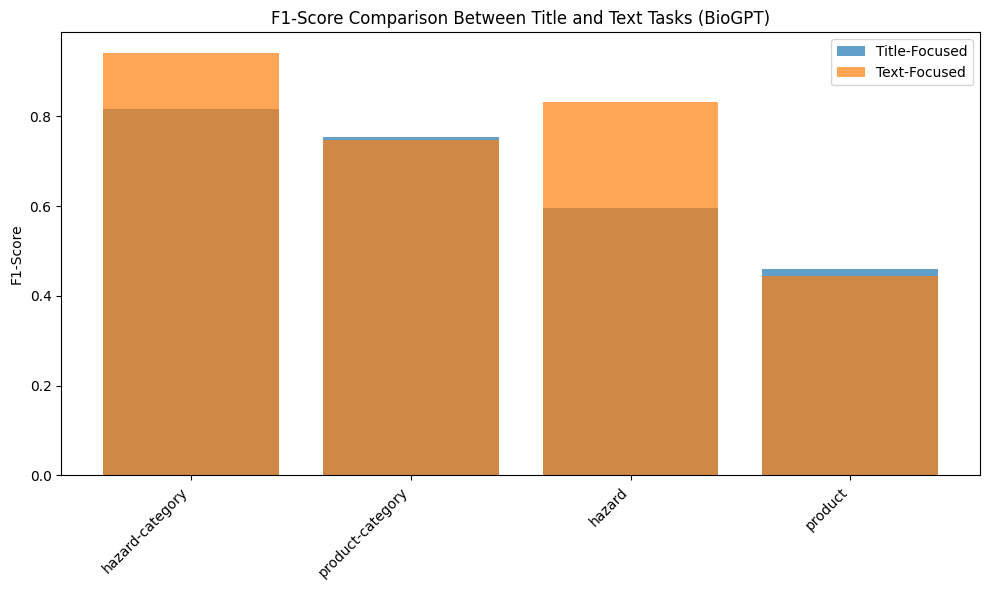

In [ ]:
# Create DataFrames for F1 scores for title and text
f1_scores_title_df = pd.DataFrame({
    'Task': targets_subtask1 + targets_subtask2,
    'F1-Score': title_f1_scores
})

f1_scores_text_df = pd.DataFrame({
    'Task': targets_subtask1 + targets_subtask2,
    'F1-Score': text_f1_scores
})

# Print the collected F1-scores for title
print("\nCollected F1-Scores for Title-Focused Classification (BioBert):")
print(f1_scores_title_df)

# Print the collected F1-scores for text
print("\nCollected F1-Scores for Text-Focused Classification (BioBert):")
print(f1_scores_text_df)

# Plot F1-scores for visual comparison
plt.figure(figsize=(10, 6))
plt.bar(f1_scores_title_df['Task'], f1_scores_title_df['F1-Score'], alpha=0.7, label='Title-Focused')
plt.bar(f1_scores_text_df['Task'], f1_scores_text_df['F1-Score'], alpha=0.7, label='Text-Focused')
plt.ylabel("F1-Score")
plt.title("F1-Score Comparison Between Title and Text Tasks (BioBert)")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()
